# 用resnet网络识别Petface

## 查看/更改网络结构
先加载预训练好的resnet网络，选它而不选vgg是因为它参数更小

In [17]:
import torch
import torchvision
Net=torchvision.models.resnet18(pretrained=True)


先查看网络结构

In [18]:
print(Net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

用nn.Identity()替换掉分类层，不要用del，因为forward中仍然有关于`x=fc(x)`的部分，Identity()可以把输入作为输出。这样查看经过分类层后flatten的数据大小

In [20]:
import torch.nn as nn
Net.fc=nn.Identity()
print(Net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 依旧用Imagefolder处理数据集
数据集用的是“1.CNN卷积神经网络中的Petfaces”,  注意，这里用了resnet预训练模型，它默认输入图片会经过标准化以下，这里和从0训练时的标准化是不一样的。

In [48]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((112,112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

dataset=ImageFolder("Petfaces",transform=transform)
train_size=int(0.85*len(dataset))
test_size=len(dataset)-train_size
train_dataset,test_dataset=torch.utils.data.random_split(dataset,[train_size,test_size])

classes=dataset.classes
num_classes=len(classes)
print(num_classes)

37


In [49]:
from torch.utils.data import DataLoader
train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=64,shuffle=False)
data_loadr=train_loader,test_loader

选择一张输入，记得用unsqueeze扩展维度，因为model设计的输入是4维，要传进去一批的大小

In [50]:
pic=dataset[0][0]
print(pic.shape)
result=Net(pic.unsqueeze(0))
print(result.shape)


torch.Size([3, 112, 112])
torch.Size([1, 37])


可以看到经过特征层输出为512,这样就可以确定分类层的输入维度，然后重写分类层

In [52]:
Net.fc=nn.Sequential(
    nn.Linear(in_features=512,out_features=256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(in_features=256,out_features=num_classes)
)
#冻结前面层，只解冻分类层
for param in Net.parameters():
    param.requires_grad=False
Net.fc[0].weight.requires_grad=True
Net.fc[3].weight.requires_grad=True

更优雅的写法是用Net.named_children(),它会获得Net的一级子模块和名字，用名字来区分是否冻结

In [53]:
for name,child in Net.named_children():
    if name !="fc":
        for param in child.parameters():
            param.requires_grad=False
    else:
        for param in child.parameters():
            param.requires_grad=True


## 训练模块

In [54]:
def validation(model,device,test_loader,loss_fn):
    model.eval()
    correct=0
    correct_3=0
    total_loss=0
    length=0
    with torch.no_grad():
        for images,labels in test_loader:
            images=images.to(device)
            labels=labels.to(device)

            result=model(images)
            loss=loss_fn(result,labels)

            total_loss+=loss.item()
            predict=torch.argmax(result,dim=1)
            correct+=torch.sum(predict==labels).item()

            _,top_3=torch.topk(result,3)
            correct_3+=torch.sum((top_3==labels.unsqueeze(1)).any(dim=1))
            length+=len(labels)

    return total_loss/len(test_loader),correct/length,correct_3/length


In [57]:
import os
def train_with_earlystop(model,device,dataloader,loss_fn,optimizer,epochs=10):
    model.to(device)
    train_loader,test_loader=dataloader
    best_loss=float('inf')
    patience=5
    checkpoint=None

    for epoch in range(epochs):
        model.train()
        for idx,(images,labels) in enumerate(train_loader):
            images=images.to(device)
            labels=labels.to(device)

            result=model(images)
            loss=loss_fn(result,labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (idx+1) % 10 == 0:
                print(f"loss:{loss.item()}")

        #
        test_loss,acc,acc_3=validation(model,device,test_loader,loss_fn)
        print(f"test_loss:{test_loss},acc:{acc},acc_3:{acc_3}")

        if(test_loss<best_loss):
            best_loss=test_loss
            patience=5
            checkpoint={
                'epoch':epoch,
                "model":model.state_dict(),
                "optimizer":optimizer.state_dict(),
                "loss":test_loss,
            }
        else:
            patience-=1
            if patience==0:
                print("Early stopping!")
                break

    # 保存模型
    if checkpoint:
        root = "save_model"
        if not os.path.exists(root):
            os.makedirs(root)
        torch.save(checkpoint,f"{root}/checkpoint{test_loss}.pth")


In [58]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(Net.parameters(),lr=0.0001)
device="cuda" if torch.cuda.is_available() else "cpu"
train_with_earlystop(Net,device,data_loadr,loss_fn,optimizer)

loss:3.082127094268799
loss:3.3650755882263184
loss:3.2977347373962402
loss:3.2284767627716064
loss:3.1018691062927246
loss:2.9185540676116943
loss:2.9824411869049072
loss:2.8631317615509033
loss:2.948700189590454


ValueError: too many values to unpack (expected 2)

### 微调
当只训练分类层acc上不去时，可以开始解冻前面的卷积层，可以把top1的正确率从65%提高到76%。

In [ ]:
for name,child in Net.named_children():
    if name =="layer4":
        for param in child.parameters():
            param.requires_grad=True


但我发现最快的方法居然是把图像放大为224，224，这样只调整分类器都有85%...，加上解冻可以来到91%
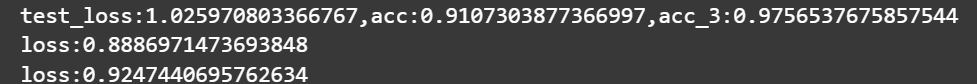